In [1]:
import math 
import os
from pathlib import Path
import heapq
from collections import *
import time

import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
BASE_PATH = Path('/Users/vinay/ub/spring-22/CSE573-CVIP/BackgroundStitching/images/pano')

In [3]:
# def gray(img):
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     return img

# def otsu(img, bt=5, t=127):
#     g = gray(img)
#     b = cv2.medianBlur(g, bt)
#     res = cv2.adaptiveThreshold(b, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 4)
#     return res

# def count_black(img, span=20):
#     h, w, _ = shape(img)
#     counts = []
    
#     for i in range(0, w, span):
#         region = img[:, i:i+span]
#         b_count = len(np.where(region == 0.0)[0])
#         counts.append(b_count)
        
#     return counts

# def estimate_overlap(img1, img2, span=20):
#     img1 = otsu(img1, bt=1, t=127)
#     img2 = otsu(img2, bt=1, t=127)
    
#     bc1 = count_black(img1, span)
#     bc2 = count_black(img2, span)
#     min_val = float('inf')
#     jmin = None
    
#     for i in range(10):
#         a = np.array(bc1[i:i+10])
#         b = np.array(bc2[i:i+10])
#         a_minus_b = np.abs(a-b)
#         ab_mean = a_minus_b.mean()
#         if ab_mean < min_val:
#             min_val = ab_mean
#             jmin = i
            
#     print(jmin)
#     o1 = (0, 0, (img1.shape[1] - jmin * span), img1.shape[0])
#     o2 = (span*jmin, 0, (img2.shape[1] - jmin * span), img2.shape[0])
            
#     return o1, o2

# o1, o2 = estimate_overlap(imgs1[2], imgs1[3])
# show(imgs1[2][o1[1]:o1[3], o1[0]:o1[2]])
# show(imgs1[3][o2[1]:o2[3], o2[0]:o2[2]])

In [56]:
def resize(img, factor):
    h, w, a = shape(img)
    op = cv2.resize(img, (int(w*factor), int(h*factor)))
    return op

def show_batch(imgs, size=20, dpi=100):
    n = len(imgs)
    col = 4
    row = (n // col) + 1 
    fig = plt.figure(figsize=(size, size), dpi=dpi)
    grid = ImageGrid(
        fig, 111,
        nrows_ncols=(row, col), 
        axes_pad=0.4, 
     )
    
    for idx, (ax, im) in enumerate(zip(grid, imgs)):
        # Iterating over the grid returns the Axes.
        im= cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        ax.imshow(im, cmap='gray')
        ax.set_title(f'Image {idx}')
        
    plt.show()

def read_batch(path, scale_factor = 1.0):
    imgs = {}
    lis = list(os.walk(path))
    
    if lis:
        p, _, files = lis[0]
        idx = 0
        for file in files:
            if '.DS_Store' not in file:
                imgs[idx] = cv2.imread(f'{p}/{file}')
                if scale_factor != 1.0:
                    imgs[idx] = resize(imgs[idx], scale_factor)
                idx += 1

    return imgs

def show(img, dpi=100, disable_axis=True, color=True):
    if color:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    plt.figure(dpi=dpi)
    plt.imshow(img, cmap='gray')
    
    if disable_axis:
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        
def shape(img):
    s = img.shape
    a = 0
    if len(s) == 3:
        h, w, a = img.shape
    else:
        h, w = img.shape
        
    return h, w, a

def img2c(img):
    size = img.shape
    return (0, 0, size[1], size[0])

def extract_features(image, extractor):
    keypoints, desc = extractor.detectAndCompute(image, None)
    return keypoints, desc

def extract_all_features(imgs):
    sift = cv2.SIFT_create()
    feature_desc = np.array(
        list(map(lambda x: extract_features(x, sift), imgs)),
        dtype=object,
    )[:, 1]
    
    return feature_desc

def pairwise(X, Y):
    dists = -2 * np.dot(X, Y.T) + np.sum(np.square(Y), axis=1, keepdims=True).T + np.sum(np.square(X), axis=1, keepdims=True)
    return np.sqrt(dists)

def get_matching_points(matches, kp1, kp2):
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ])
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ])
    return src_pts, dst_pts

def match_desc(desc1, desc2, lowes_ratio):
    pair_dist = pairwise(desc1, desc2)
    min_pairs = np.partition(pair_dist, 1)[:, :2]
    idx = (min_pairs[:, 0] / min_pairs[:, 1]) < lowes_ratio
    n_matches = len(min_pairs[idx])
    matches = []

    for q_idx, t_idx in zip(np.nonzero(idx)[0], np.argmin(pair_dist[idx], 1)):
        matches.append(
            cv2.DMatch(
                _queryIdx=q_idx,
                _trainIdx=t_idx,
                _distance=pair_dist[q_idx, t_idx],
            )
        )
        
    return matches, n_matches

def homography(match_pts, cv=True):
    src_pts, dst_pts = match_pts
    k = cv2.RANSAC if cv is True else 0
    
    if len(src_pts) > 4:
        h, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5)
    else:
        h, mask = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]]), None
    
    if isinstance(mask, NoneType):
        print(f'after h: inliers: {mask.sum()}')
    
    return h, mask

def translate(dx, dy):
    t = np.float32(
        [
            [1, 0, dx],
            [0, 1, dy],
            [0, 0,  1],
        ]
    )
    return t

def translate_homography(dx, dy, H):
    dx, dy = abs(dx) if dx < 0 else 0, abs(dy) if dy < 0 else 0
    transform = np.float32(
        [
            [1, 0, dx],
            [0, 1, dy],
            [0, 0,  1],
        ]
    )
    new_h = transform.dot(H)
    return new_h, (dx, dy)

def apply_homography(args, img1, img2, H, mask):
    img1 = img1.copy()
    img2 = img2.copy()
    
    h, w, _ = shape(img1)
    (matches, (kp1, kp2)) = args
    
    pts = np.float32([ [0, 0],[0, h-1],[w-1, h-1],[w-1, 0] ]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, H)
    img2 = cv2.polylines(img2, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
    
    draw_params = dict(
        matchColor = (0, 255, 0), 
        singlePointColor = None,
        matchesMask = mask,
        flags = 2,
    )
    img = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, **draw_params)
    
    return img

def transform(coordinates, homography):
    x, y, w, h = coordinates
    src = np.float32([[x, y], [x, y + h - 1], [x + w - 1, y], [x + w - 1, y + h - 1]]).reshape(-1, 1, 2)
    
    dst = cv2.perspectiveTransform(src, homography)
    l, _, _ = dst.shape
    dst = dst.reshape((l, 2))
    
    min_x, max_x = np.min(dst[:, 0]), np.max(dst[:, 0])
    min_y, max_y = np.min(dst[:, 1]), np.max(dst[:, 1])
    
    new_x = int(np.floor(min_x))
    new_y = int(np.floor(min_y))
    new_w = int(np.ceil(max_x - min_x))
    new_h = int(np.ceil(max_y - min_y))
    
    return new_x, new_y, new_w, new_h

def addBorder(img, rect):
    top, bottom, left, right = int(0), int(0), int(0), int(0)
    x, y, w, h = rect
    tl = (x, y)    
    br = (x + w, y + h)
    if tl[1] < 0:
        top = -tl[1]
    if br[1] > img.shape[0]:
        bottom = br[1] - img.shape[0]
    if tl[0] < 0:
        left = -tl[0]
    if br[0] > img.shape[1]:
        right = br[0] - img.shape[1]
        
    img = cv2.copyMakeBorder(img, top, bottom, left, right,
                            cv2.BORDER_CONSTANT, value=[0, 0, 0])
    orig = (left, top)
    return img, orig

def mean_blend(img1, img2):
    assert(img1.shape == img2.shape)
    locs1 = np.where(cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY) != 0)
    blended1 = np.copy(img2)
    blended1[locs1[0], locs1[1]] = img1[locs1[0], locs1[1]]
    locs2 = np.where(cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY) != 0)
    blended2 = np.copy(img1)
    blended2[locs2[0], locs2[1]] = img2[locs2[0], locs2[1]]
    blended = cv2.addWeighted(blended1, 0.5, blended2, 0.5, 0)
    return blended

def warp(img_c, H):
    _, _, a = shape(img_c)
    dx, dy, _, _ = transform(img2c(img_c), H)
    new_H, (tx, ty) = translate_homography(dx, dy, H)
    x, y, w, h = transform(img2c(img_c), new_H)
    warped = cv2.warpPerspective(img_c, new_H, (x+w, y+h))
    # print(f'xpos:{dx}, ypos:{dy}')
    return warped, (tx, ty)

def merge(img1_c, img2_c, H):
    result, pos = warp(img1_c, H)
    xpos, ypos = pos
    # print(f'xpos:{xpos}, ypos:{ypos}')
    rect = (xpos, ypos, img2_c.shape[1], img2_c.shape[0])
    result, _ = addBorder(result, rect)
    idx = np.s_[ypos : ypos + img2_c.shape[0], xpos : xpos + img2_c.shape[1]]
    result[idx] = mean_blend(result[idx], img2_c)
    x, y, w, h = cv2.boundingRect(cv2.cvtColor(result, cv2.COLOR_RGB2GRAY))
    result = result[y : y + h, x : x + w]
    
    return result, (xpos-x, ypos-y)

def ransac(match_pts, thresh, factor, p=10, n=10000, prob=0.99):
    src_pts, dst_pts = match_pts
    k = len(src_pts)
    
    min_error = float('inf')
    best_inliers = float('-inf')
    mask = []
    src_pts_f = []
    dest_pts_f = []
    print('\n')
    for i in range(n):
        rand_idx = np.random.choice(k, p)
        src_pts_s = src_pts[rand_idx]
        dst_pts_s = dst_pts[rand_idx]

        H, _ = cv2.findHomography(src_pts_s.reshape(-1, 1, 2), dst_pts_s.reshape(-1, 1, 2))
        dst_pts_p = cv2.perspectiveTransform(src_pts.reshape(-1, 1, 2), H).reshape(-1, 2)

        errors = np.linalg.norm(dst_pts_p - dst_pts, axis=1)
        errors = errors / factor
        inliers = errors < thresh
        n_inliers = inliers.sum()
        
        if n_inliers > best_inliers:
            mean_error = round(errors.mean(), 2)
            print(f'idx:{i}, mean_error:{mean_error}, n_inliers:{n_inliers}, prob:{round(n_inliers/k, 2)}')
            best_inliers = n_inliers
            src_pts_f = src_pts[inliers]
            dest_pts_f = dst_pts[inliers]
            mask = inliers
            
        if n_inliers/k > prob:
            # print('break')
            break

    return src_pts_f, dest_pts_f, mask.astype(np.uint8)

def remove_border(img):
    x, y, w, h = cv2.boundingRect(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    img = img[y : y + h, x : x + w]
    return img

def get_H(
    img1_c, img2_c, ransac_thresh,
    matches, kp1, kp2, cv,
):
    sift = cv2.SIFT_create()
    img1 = cv2.cvtColor(img1_c, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2_c, cv2.COLOR_BGR2GRAY)
    
    h1, w1 = img1.shape
    h2, w2 = img2.shape
    
    src_pts, dst_pts = get_matching_points(matches, kp1, kp2)
    
    if cv is False:
        K = math.sqrt((h1 + h2)**2 + (w1 + w2)**2)
        src_pts, dst_pts, mask = ransac(
            (src_pts, dst_pts), thresh=ransac_thresh, factor=1,
        )
        print(f'after ransac n_matches: {len(src_pts)}')
        
    H, _ = homography((src_pts, dst_pts), cv=True)
    
    return H

def stitch(img1, img2, ransac_thresh, matches, kp1, kp2, cv):
    H = get_H(
        img1, img2, ransac_thresh=ransac_thresh,
        matches=matches, kp1=kp1, kp2=kp2, cv=cv,
    )
    img, _ = merge(img1, img2, H)
    return img

def pano(
    imgs, descriptors, keypoints, 
    extractor, match_thresh, ransac_thresh, 
    lowes_ratio, show_inter, cv,
):
    nxt_imgs = []
    nxt_desc = []
    nxt_kp = []
    n = len(imgs)
    helper = np.ones(n)
    curr = 0
    flag = True
    
    while True:
        curr = np.where(helper == 1)[0][0]
        helper[curr] = 0
        
        best_n = float('-inf')
        best_nxt = None
        best_matches = []
        
        for nxt in np.where(helper == 1)[0]:
            matches, n_matches = match_desc(
                descriptors[nxt],
                descriptors[curr],
                lowes_ratio=lowes_ratio,
            )
            # matches, n_matches = match_desc(
            #     descriptors[curr],
            #     descriptors[nxt],
            #     lowes_ratio=lowes_ratio,
            # )
            print(f'curr:{curr}, nxt:{nxt}, n_matches:{n_matches}')
            if n_matches > best_n and n_matches > match_thresh:
                best_n = n_matches
                best_nxt = nxt
                best_matches = matches
                
        # print(f'best_nxt: {best_nxt}')
        
        if best_nxt is not None:
            print(f'curr:{curr}, best_nxt:{best_nxt}, n_matches:{best_n}')
            helper[best_nxt] = 0
            stitched_img = stitch(
                img1=imgs[best_nxt], img2=imgs[curr], cv=cv, 
                kp1=keypoints[best_nxt], kp2=keypoints[curr],
                ransac_thresh=ransac_thresh, matches=best_matches,
            )
            # stitched_img = stitch(
            #     img1=imgs[curr], img2=imgs[best_nxt], cv=cv, 
            #     kp1=keypoints[curr], kp2=keypoints[best_nxt],
            #     ransac_thresh=ransac_thresh, matches=best_matches,
            # )
            nxt_imgs.append(stitched_img)
            
            kps, fds = extract_features(nxt_imgs[-1], extractor)
            nxt_desc.append(fds)
            nxt_kp.append(kps)
            
            print(f'\nStitched {curr}, {best_nxt} | shape: {nxt_imgs[-1].shape}\n')
            
            if show_inter:
                show(nxt_imgs[-1])
        elif flag is False:
            nxt_imgs.append(imgs[curr])
            nxt_desc.append(descriptors[curr])
            nxt_kp.append(keypoints[curr])
            
        flag = False
        if np.where(helper == 1)[0].shape[0] == 0:
            break
            
    return nxt_imgs, nxt_desc, nxt_kp

def stitch_pano(
    imgs, ransac_thresh=0.015, match_thresh=200,
    lowes_ratio=0.6, show_inter=False, cv=True,
):
    sift = cv2.SIFT_create()
    descriptors = []
    keypoints = []
    
    for idx, img in enumerate(imgs):
        kp, desc = extract_features(img, sift)
        keypoints.append(kp)
        descriptors.append(desc)
        
    count = 0
    while imgs:
        print('------------------------------')
        print(f'iter: {count}, imgs: {len(imgs)}\n')
        imgs, descriptors, keypoints = pano(
            imgs=imgs, descriptors=descriptors, keypoints=keypoints, 
            extractor=sift, match_thresh=match_thresh, 
            ransac_thresh=ransac_thresh, lowes_ratio=lowes_ratio,
            show_inter=show_inter, cv=cv,
        ) 
        if len(imgs) != 0:
            res = imgs
        count += 1
    return res

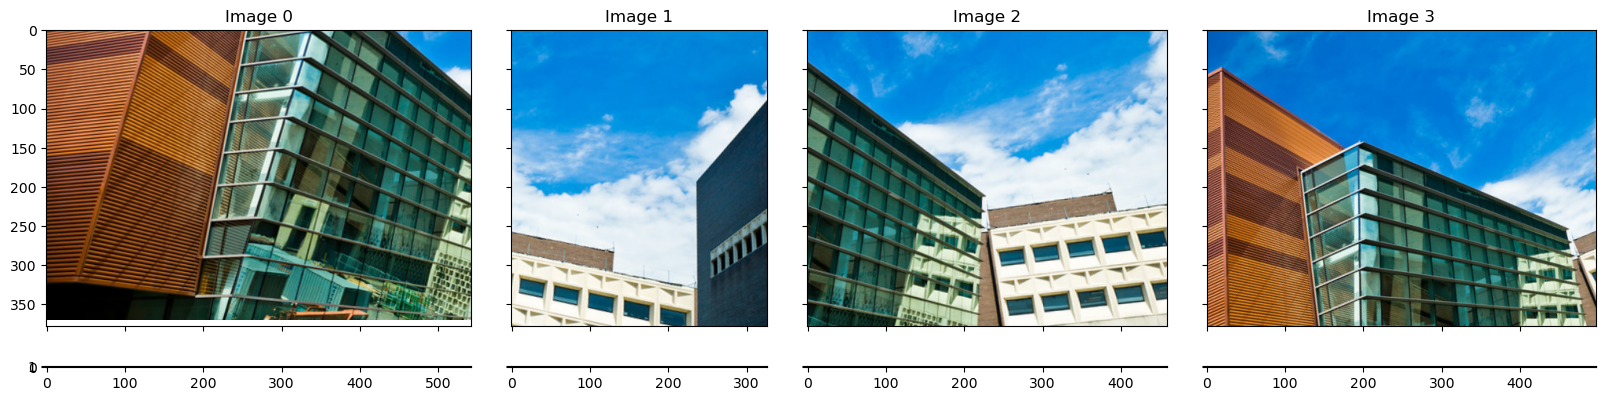

In [5]:
imgs1 = read_batch(BASE_PATH/'1')
show_batch(imgs1.values())

------------------------------
iter: 0, imgs: 4

curr:0, nxt:1, n_matches:2
curr:0, nxt:2, n_matches:435
curr:0, nxt:3, n_matches:317
curr:0, best_nxt:2, n_matches:435


idx:0, mean_error:3.5199999809265137, n_inliers:435, prob:1.0
after ransac n_matches: 435
after h: inliers: 409

Stitched 0, 2 | shape: (449, 859, 3)

curr:1, nxt:3, n_matches:17
------------------------------
iter: 1, imgs: 3

curr:0, nxt:1, n_matches:134
curr:0, nxt:2, n_matches:414
curr:0, best_nxt:2, n_matches:414


idx:0, mean_error:5.800000190734863, n_inliers:414, prob:1.0
after ransac n_matches: 414
after h: inliers: 387

Stitched 0, 2 | shape: (665, 859, 3)

------------------------------
iter: 2, imgs: 2

curr:0, nxt:1, n_matches:122
curr:0, best_nxt:1, n_matches:122


idx:0, mean_error:21.729999542236328, n_inliers:122, prob:1.0
after ransac n_matches: 122
after h: inliers: 98

Stitched 0, 1 | shape: (665, 1010, 3)

------------------------------
iter: 3, imgs: 1



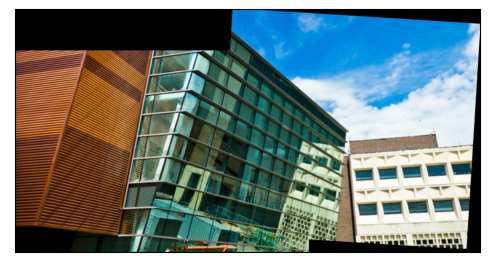

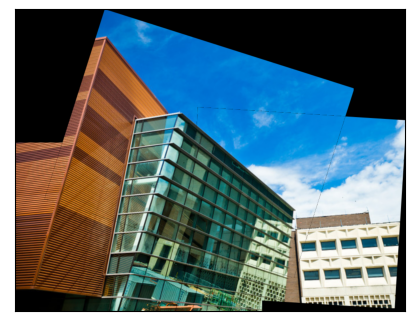

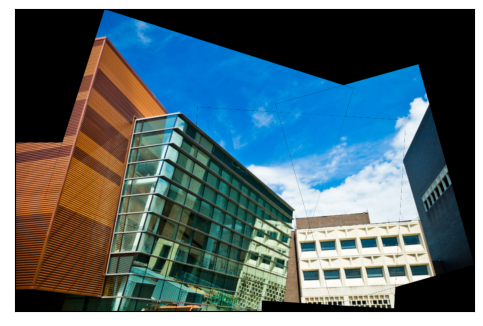

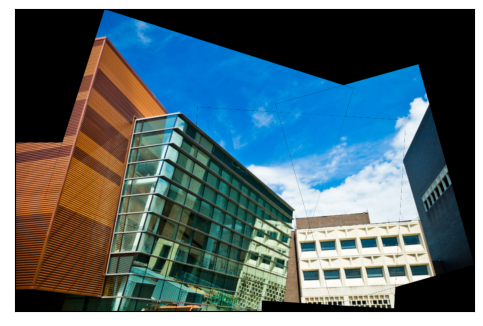

In [47]:
# %%timeit
res = stitch_pano(
    list(imgs1.values()), ransac_thresh=5000, match_thresh=100, lowes_ratio=0.7, cv=False, show_inter=True,
)
show(res[0])

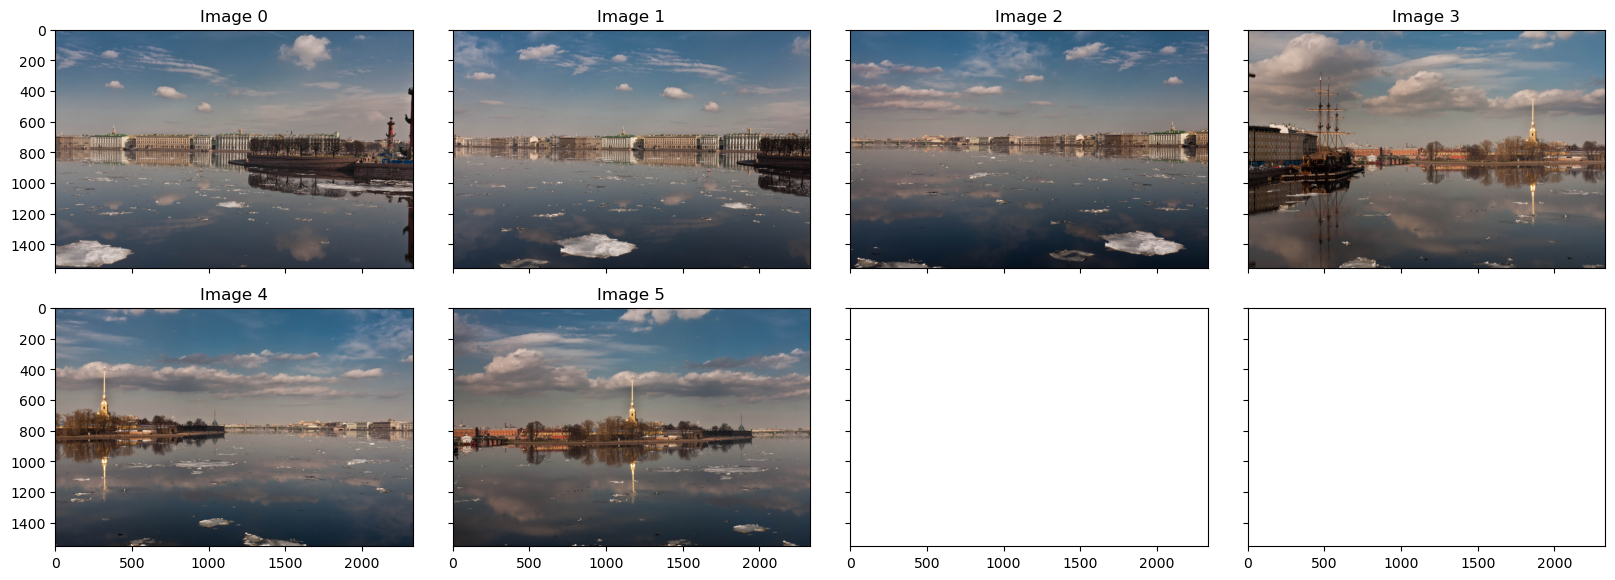

In [7]:
imgs2 = read_batch(BASE_PATH/'2', 0.6)
show_batch(imgs2.values())

------------------------------
iter: 0, imgs: 4

curr:0, nxt:1, n_matches:2508
curr:0, nxt:2, n_matches:920
curr:0, nxt:3, n_matches:35
curr:0, best_nxt:1, n_matches:2508


idx:0, mean_error:9.430000305175781, n_inliers:2448, prob:0.98
idx:2, mean_error:10.59000015258789, n_inliers:2451, prob:0.98
idx:276, mean_error:12.789999961853027, n_inliers:2452, prob:0.98
idx:802, mean_error:14.100000381469727, n_inliers:2453, prob:0.98
idx:3483, mean_error:14.369999885559082, n_inliers:2454, prob:0.98
after ransac n_matches: 2454
after h: inliers: 1806

Stitched 0, 1 | shape: (1821, 3303, 3)

curr:2, nxt:3, n_matches:22
------------------------------
iter: 1, imgs: 3

curr:0, nxt:1, n_matches:1612
curr:0, nxt:2, n_matches:25
curr:0, best_nxt:1, n_matches:1612


idx:0, mean_error:16.350000381469727, n_inliers:1576, prob:0.98
idx:54, mean_error:16.809999465942383, n_inliers:1577, prob:0.98
idx:8758, mean_error:24.280000686645508, n_inliers:1578, prob:0.98
after ransac n_matches: 1578
after h: inl

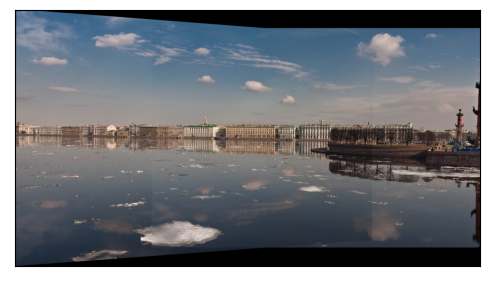

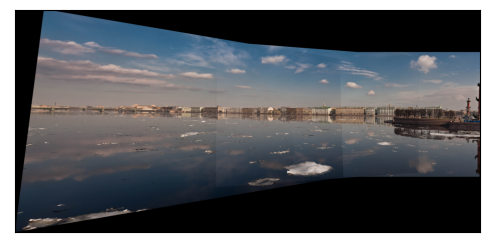

In [48]:
res = stitch_pano(
    list(imgs2.values())[:-2], ransac_thresh=50, match_thresh=50, lowes_ratio=0.7, cv=False, show_inter=True,
)

------------------------------
iter: 0, imgs: 4

curr:0, nxt:1, n_matches:2957
curr:0, nxt:2, n_matches:1167
curr:0, nxt:3, n_matches:166
curr:0, best_nxt:1, n_matches:2957


idx:0, mean_error:80.3499984741211, n_inliers:243, prob:0.08
idx:1, mean_error:41.70000076293945, n_inliers:2552, prob:0.86
idx:9, mean_error:40.84000015258789, n_inliers:2576, prob:0.87
idx:12, mean_error:41.150001525878906, n_inliers:2599, prob:0.88
idx:415, mean_error:41.029998779296875, n_inliers:2601, prob:0.88
idx:546, mean_error:40.88999938964844, n_inliers:2602, prob:0.88
idx:551, mean_error:41.560001373291016, n_inliers:2604, prob:0.88
idx:629, mean_error:41.58000183105469, n_inliers:2612, prob:0.88
idx:3176, mean_error:42.040000915527344, n_inliers:2619, prob:0.89
after ransac n_matches: 2619
after h: inliers: 2168

Stitched 0, 1 | shape: (1820, 3294, 3)

curr:2, nxt:3, n_matches:146
curr:2, best_nxt:3, n_matches:146


idx:0, mean_error:1092.800048828125, n_inliers:0, prob:0.0
idx:136, mean_error:739.530

AttributeError: 'NoneType' object has no attribute 'shape'

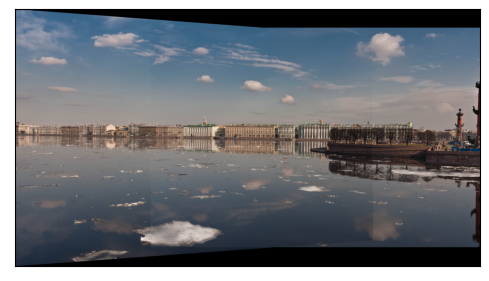

In [57]:
res = stitch_pano(
    list(imgs2.values())[:-2], ransac_thresh=10, match_thresh=50, lowes_ratio=0.8, cv=False, show_inter=True,
)

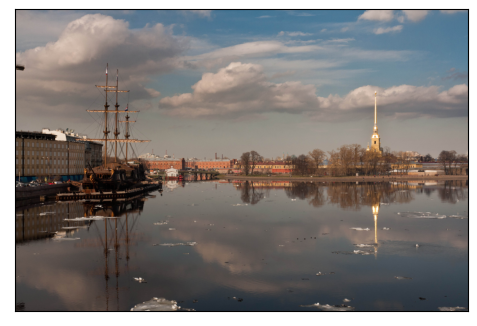

In [24]:
show(res[0])

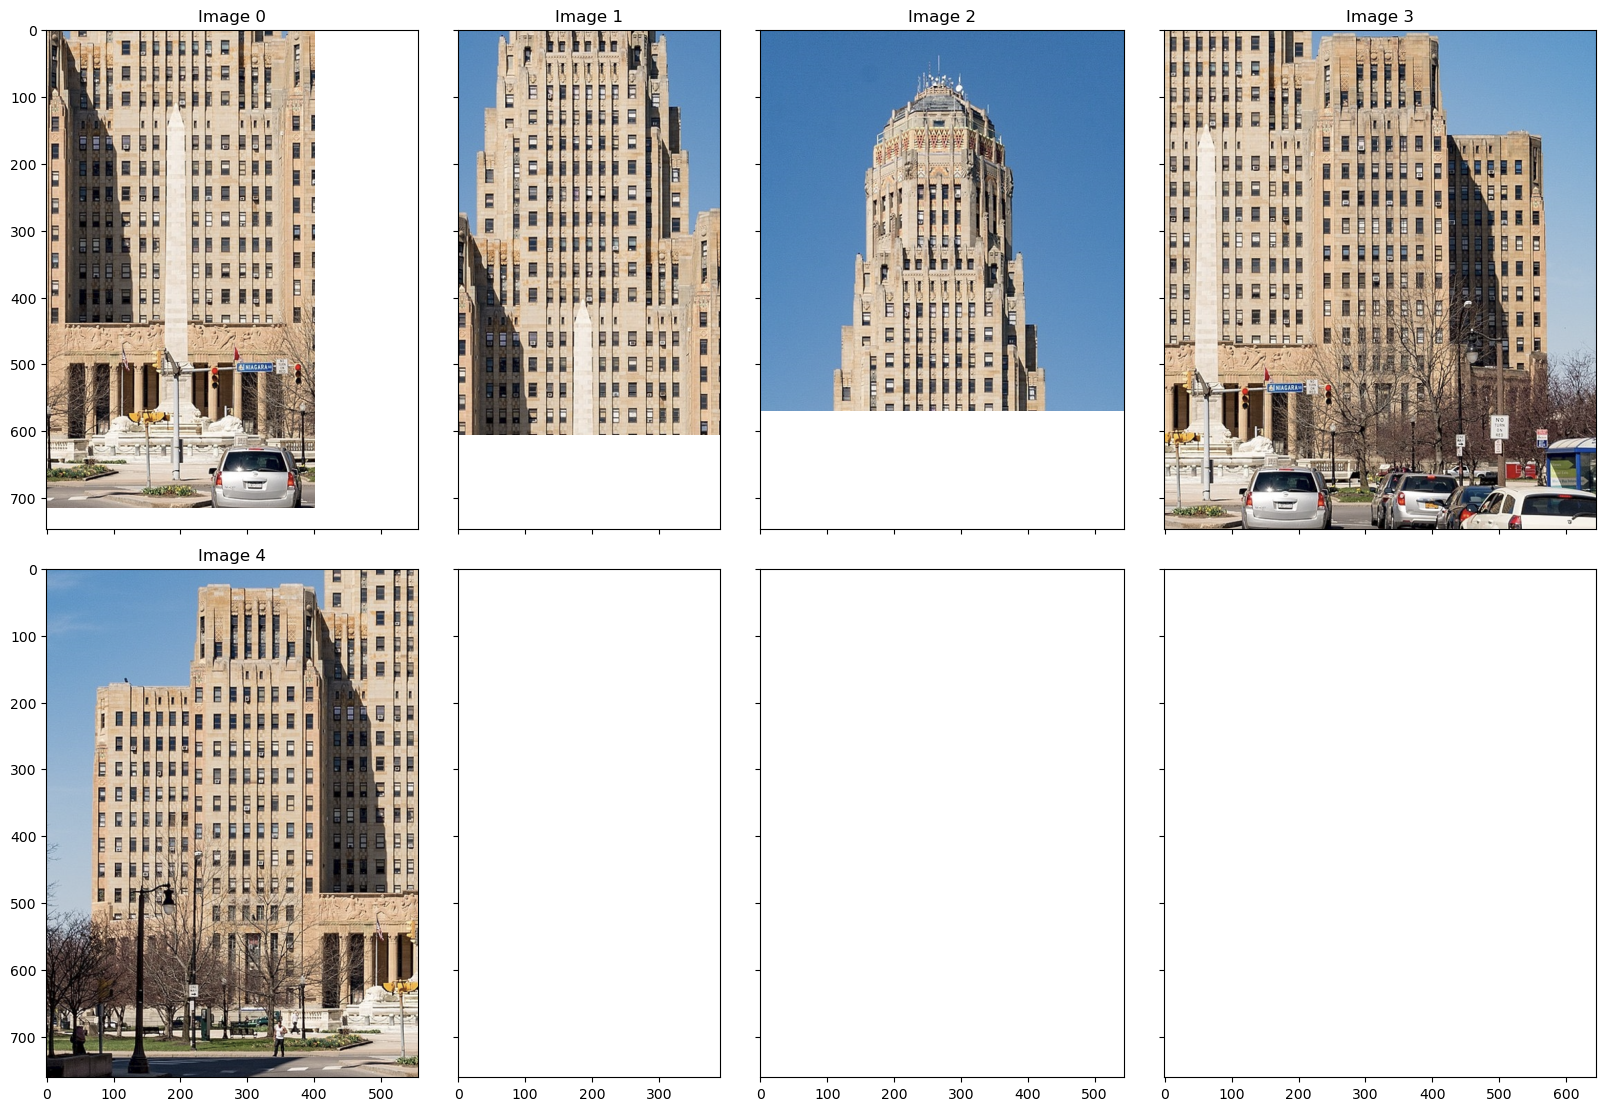

In [11]:
imgs3 = read_batch(BASE_PATH/'3')
show_batch(imgs3.values())

In [12]:
# a, b = 4, 3
# o1, o2 = estimate_overlap(imgs3[a], imgs3[b])
# show(imgs3[a][o1[1]:o1[3], o1[0]:o1[2]])
# show(imgs3[b][o2[1]:o2[3], o2[0]:o2[2]])

------------------------------
iter: 0, imgs: 5

curr:0, nxt:1, n_matches:1930
curr:0, nxt:2, n_matches:463
curr:0, nxt:3, n_matches:3011
curr:0, nxt:4, n_matches:2432
curr:0, best_nxt:3, n_matches:3011

Stitched 0, 3 | shape: (745, 775, 3)

curr:1, nxt:2, n_matches:1154
curr:1, nxt:4, n_matches:1736
curr:1, best_nxt:4, n_matches:1736

Stitched 1, 4 | shape: (1007, 780, 3)

------------------------------
iter: 1, imgs: 3

curr:0, nxt:1, n_matches:3644
curr:0, nxt:2, n_matches:457
curr:0, best_nxt:1, n_matches:3644

Stitched 0, 1 | shape: (1009, 1156, 3)

------------------------------
iter: 2, imgs: 2

curr:0, nxt:1, n_matches:1061
curr:0, best_nxt:1, n_matches:1061

Stitched 0, 1 | shape: (1334, 1156, 3)

------------------------------
iter: 3, imgs: 1



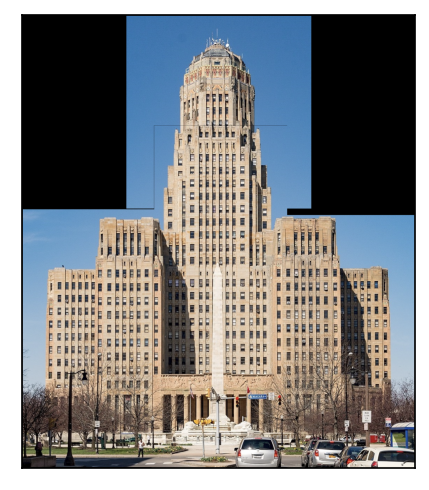

In [13]:
res = stitch_pano(list(imgs3.values()), match_thresh=150, lowes_ratio=0.9)
show(res[0], dpi=150)

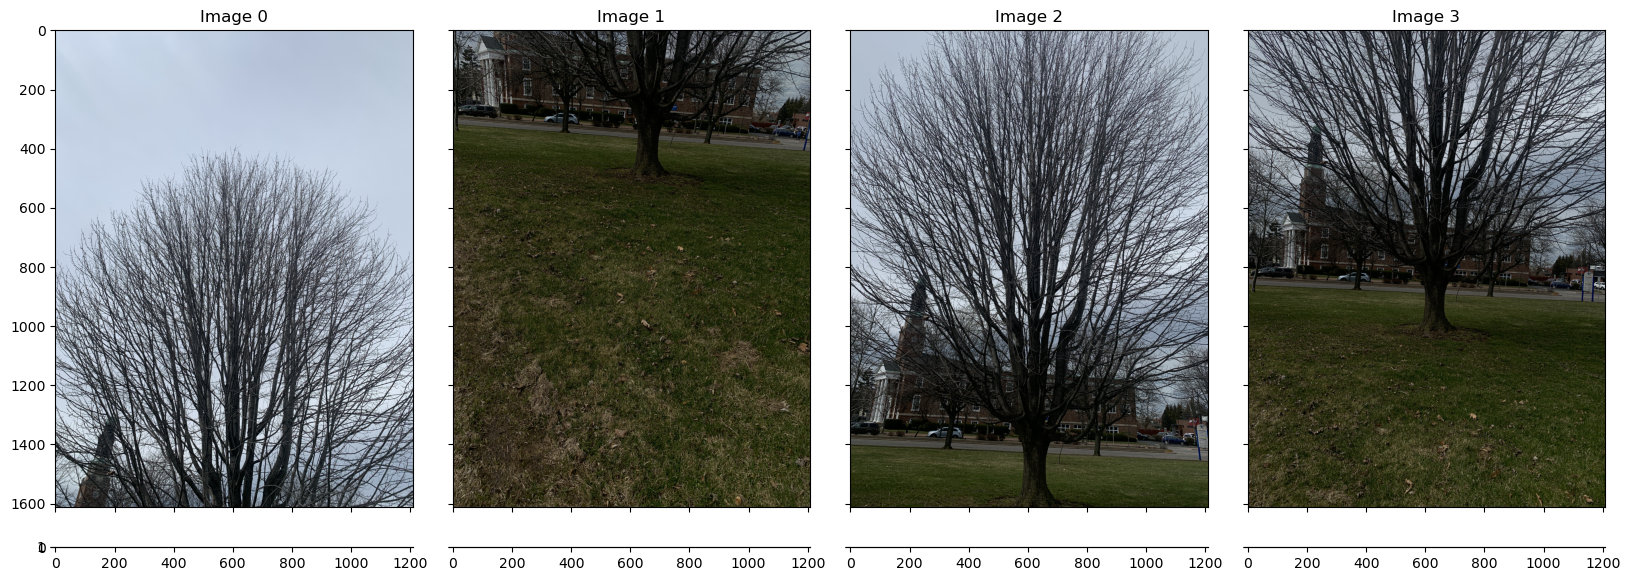

In [14]:
imgs4 = read_batch(BASE_PATH/'6', 0.4)
show_batch(imgs4.values())

------------------------------
iter: 0, imgs: 4

curr:0, nxt:1, n_matches:1
curr:0, nxt:2, n_matches:434
curr:0, nxt:3, n_matches:60
curr:0, best_nxt:2, n_matches:434


idx:0, min_error:0, n_inliers:277, prob:0.64
idx:1, min_error:0, n_inliers:407, prob:0.94
idx:14, min_error:0, n_inliers:408, prob:0.94
after ransac n_matches: 408

Stitched 0, 2 | shape: (2571, 1745, 3)

curr:1, nxt:3, n_matches:880
curr:1, best_nxt:3, n_matches:880


idx:0, min_error:0, n_inliers:797, prob:0.91
idx:1, min_error:0, n_inliers:860, prob:0.98
after ransac n_matches: 860

Stitched 1, 3 | shape: (2511, 1784, 3)

------------------------------
iter: 1, imgs: 2

curr:0, nxt:1, n_matches:113
curr:0, best_nxt:1, n_matches:113


idx:0, min_error:0, n_inliers:4, prob:0.04
idx:1, min_error:0, n_inliers:14, prob:0.12
idx:2, min_error:0, n_inliers:20, prob:0.18
idx:10, min_error:0, n_inliers:22, prob:0.19
idx:27, min_error:0, n_inliers:39, prob:0.35
idx:29, min_error:0, n_inliers:56, prob:0.5
idx:58, min_error:0, n_

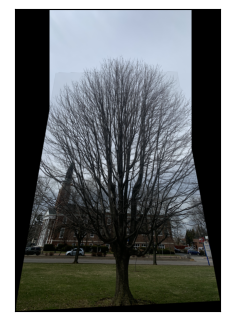

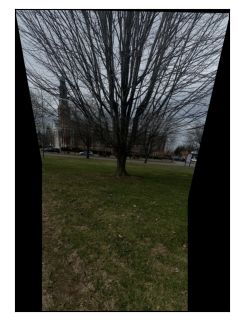

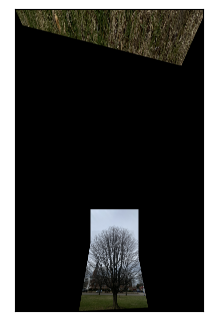

In [20]:
res = stitch_pano(
    list(imgs4.values()), ransac_thresh=0.02, match_thresh=50, lowes_ratio=0.7, cv=False, show_inter=True,
)

------------------------------
iter: 0, imgs: 4

curr:0, nxt:1, n_matches:236
curr:0, nxt:2, n_matches:1598
curr:0, nxt:3, n_matches:669
curr:0, best_nxt:2, n_matches:1598

Stitched 0, 2 | shape: (2546, 1725, 3)

curr:1, nxt:3, n_matches:1913
curr:1, best_nxt:3, n_matches:1913

Stitched 1, 3 | shape: (2555, 1822, 3)

------------------------------
iter: 1, imgs: 2

curr:0, nxt:1, n_matches:1887
curr:0, best_nxt:1, n_matches:1887

Stitched 0, 1 | shape: (7127, 4512, 3)

------------------------------
iter: 2, imgs: 1



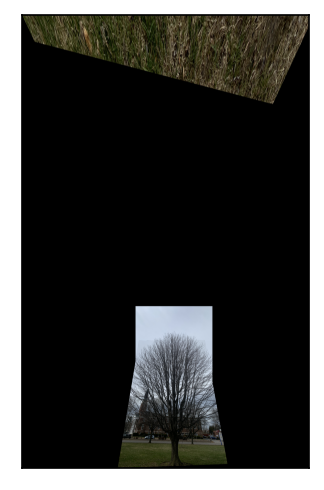

In [15]:
res = stitch_pano(list(imgs4.values()), match_thresh=150, lowes_ratio=0.85)
show(res[0], dpi=150)